In [1]:
import os
import numpy as np
import pydicom
import pandas as pd
import re
from warnings import warn
import parsing
from task1 import get_slice_set, read_slice_with_annotations
# from torch.utils.data import Dataset, DataLoader

from PIL import Image

In [2]:
from task2 import HeartDataset
from task4 import crop, crop_roi
from task4 import threshold_otsu_histogram, circle

In [3]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dir_data = 'final_data'
fn_link = f'{dir_data}/link.csv'

metadata = pd.read_csv(fn_link)
print( f'{metadata.shape[0]} series parsed')

filenames = get_slice_set(metadata, dir_data, o_contours=True, join='inner')
print( f'{filenames.shape[0]} files parsed')

5 series parsed
46 files parsed


/Users/dlituiev/repos/assigments/task1.py:108: UserWarning: some dicom slices are missing: 9 matches out of 18 contours
  f'matches out of {filenames_i_contour.shape[0]} contours')
/Users/dlituiev/repos/assigments/task1.py:108: UserWarning: some dicom slices are missing: 10 matches out of 20 contours
  f'matches out of {filenames_i_contour.shape[0]} contours')
/Users/dlituiev/repos/assigments/task1.py:108: UserWarning: some dicom slices are missing: 9 matches out of 22 contours
  f'matches out of {filenames_i_contour.shape[0]} contours')


### Exclude files with wrong o-contours

In [5]:
filenames = filenames[filenames.original_id != 'SC-HF-I-6']
print('{} files remaining'.format(filenames.shape[0]))

37 files remaining


In [6]:
filenames_train = filenames[filenames.original_id != 'SC-HF-I-1']
filenames_val = filenames[filenames.original_id == 'SC-HF-I-1']
hdset_train = HeartDataset(filenames_train, with_contour=True)
hdset_val = HeartDataset(filenames_val, with_contour=True)
len(hdset_train), len(hdset_val)

(28, 9)

In [7]:
hdset = hdset_train + hdset_val
len(hdset)

37

In [8]:
# sample


In [9]:
hdset.filenames['width'] = 0
hdset.filenames['height'] = 0
for ii, sample in enumerate(hdset):
    hdset.filenames.iloc[ii]['i_out_of_o'] = ((sample['imask'] ^ sample['omask']) & sample['imask']).sum()
    
    bbox = cv2.boundingRect(np.asarray(sample['ocontour'], dtype=int))
    hdset.filenames['width'].iloc[ii]= bbox[2]
    hdset.filenames['height'].iloc[ii] = bbox[3]

/Applications/anaconda3/envs/radiology/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Applications/anaconda3/envs/radiology/lib/python3.7/site-packages/pandas/core/series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/Applications/anaconda3/envs/radiology/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._set

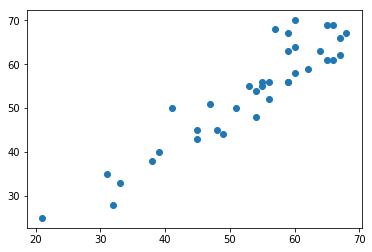

In [10]:
plt.scatter(hdset.filenames.width, hdset.filenames.height)

In [11]:
sample['image']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [12]:
# cv2.getRectSubPix(sample['image'].astype(np.uint8), bbox[-2:], (bbox[0]//2, bbox[1]//2))
height = width = 72

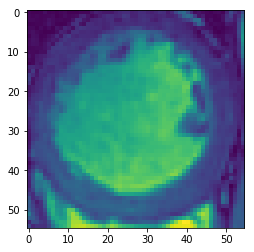

In [13]:
x0, y0, w, h = bbox
xc = x0 + w//2
yc = y0 + h//2

img = Image.fromarray(sample['image'])
plt.imshow(img.crop((x0, y0, x0+w, y0+h)))

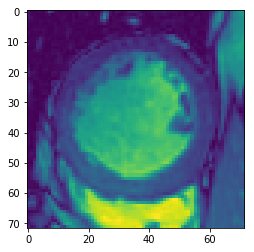

In [14]:
x0, y0, w, h = bbox
xc = x0 + w//2
yc = y0 + h//2

img = Image.fromarray(sample['image'])
plt.imshow(img.crop((xc - width//2, yc - height//2,
                     xc + width//2, yc + height//2,)))

In [15]:
def get_crop_bbox_pil(ocontour, width, height):
    bbox = cv2.boundingRect(np.asarray(ocontour , dtype=int))
    x0, y0, w, h = bbox
    xc = x0 + w//2
    yc = y0 + h//2
    crop_bbox = (xc - width//2, yc - height//2,
                 xc + width//2, yc + height//2,)
    return crop_bbox


In [16]:
def get_crop_bbox(ocontour, width, height):
    bbox = cv2.boundingRect(np.asarray(ocontour , dtype=int))
    bbox = expand_bbox(bbox, width, height)
    x0, y0, w, h = bbox
    xc = x0 + w//2
    yc = y0 + h//2
    crop_bbox = (xc - width//2, yc - height//2,
                 width, height)
    return crop_bbox

In [17]:
def expand_bbox(bbox, width, height):
    x0, y0, w, h = bbox
    xc = x0 + w//2
    yc = y0 + h//2
    crop_bbox = (xc - width//2, yc - height//2,
                 width, height)
    return crop_bbox

In [18]:
bbox
hdset.filenames.original_id.value_counts()

SC-HF-I-4    10
SC-HF-I-1     9
SC-HF-I-2     9
SC-HF-I-5     9
Name: original_id, dtype: int64

In [19]:
# tiny_imgs = []
# tiny_imasks = []
# height = width = 80

# for ii, sample in enumerate(hdset):
#     hdset.filenames.loc[ii, 'i_out_of_o'] = ((sample['imask'] ^ sample['omask']) & sample['imask']).sum()
    
#     bbox = cv2.boundingRect(np.asarray(sample['ocontour'], dtype=int))
#     hdset.filenames.loc[ii, 'width'] = bbox[2]
#     hdset.filenames.loc[ii, 'height'] = bbox[3]
    
#     large_bbox = expand_bbox(bbox, height, width)
#     tiny_img = (crop(large_bbox, sample['omask'])*
#             crop(large_bbox, sample['image']))
#     tiny_imgs.append(tiny_img)
#     tiny_imasks.append( crop(large_bbox,sample['imask']) )
    
# tiny_imasks = np.stack(tiny_imasks)
# tiny_imgs = np.stack(tiny_imgs)

In [20]:
# hdset_val.filenames

In [21]:
# tiny_imasks.shape, tiny_imgs.shape

In [22]:
hdset.filenames['val_set'] = hdset.filenames.original_id == 'SC-HF-I-1'

In [23]:
# tiny_imasks[hdset.filenames['val_set']]

In [24]:
import keras
from keras import backend as K
from keras.models import Model, load_model

Using TensorFlow backend.


In [25]:
def dice_coef_binary(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 2 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten((K.cast(y_true, 'int32')))
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary(y_true, y_pred)

In [26]:
import imgaug.augmenters as iaa
import imgaug as ia
# iaa.seed(2)

seq = iaa.Sequential([
    iaa.CoarseDropout(0.1, size_percent=0.2),
    iaa.ElasticTransformation(alpha=10, sigma=1),
    iaa.Affine(
            scale=1.2,
            translate_percent=(5),
            translate_px=None,
            rotate=(-30, 30),
            shear=(5.0),
        ),
])

In [27]:
# from keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import Dataset, DataLoader
from task2 import np_collate

In [28]:
class TinyImgDataset(Dataset):
    """An class representing cropped images on o-mask with i-mask labels
    """
    def __init__(self, other, width=80, height=80,):
        self.filenames = other.filenames.reset_index(drop=True)
#         self.with_contour = with_contour
        self.height = height
        self.width = width
        self.images = []
        self.masks = []
        self.contours = []
        for ii, sample in enumerate(other):
            self.filenames.loc[ii, 'i_out_of_o'] = ((sample['imask'] ^ sample['omask']) & sample['imask']).sum()

            bbox = cv2.boundingRect(np.asarray(sample['ocontour'], dtype=int))
            self.filenames.loc[ii, 'width'] = bbox[2]
            self.filenames.loc[ii, 'height'] = bbox[3]

            large_bbox = expand_bbox(bbox, self.height, self.width)
            tiny_img = (crop(large_bbox, sample['omask'])*
                    crop(large_bbox, sample['image']))
            
            tiny_contour = crop_roi(large_bbox, sample['icontour'])
            
            self.images.append(tiny_img)
            self.masks.append( crop(large_bbox,sample['imask']) )
            self.contours.append(tiny_contour)

        self.masks = np.stack(self.masks)
        self.images = np.stack(self.images)

    def __getitem__(self, index):
        return self.images[index], self.masks[index], self.contours[index]
#         slicedict = self.filenames.iloc[index]
#         sample = read_slice_with_annotations(slicedict,
#                                              with_contour=self.with_contour)
        return sample

    def __len__(self):
        return len(self.filenames)

#     def __add__(self, other):
#         return HeartDataset(pd.concat[self.filenames, other.filenames])


In [29]:
# hdset_train[0]
hdset_train.filenames = hdset_train.filenames[~hdset_train.filenames.dicoms.isnull()]

In [30]:
timgset_train = TinyImgDataset(hdset_train)

In [31]:
timgset_val = TinyImgDataset(hdset_val)

In [32]:
dloader_train = DataLoader(timgset_train, collate_fn=np_collate, 
                           batch_size=4, shuffle=True)

In [33]:
len(dloader_train)

7

In [34]:
def batchgen(dloader):
    while True:
        for img, msk, _ in dloader:
            bg = seq(images=img, 
                     segmentation_maps=msk,
                    return_batch=True,
                    )
            yield np.stack([bg.images_aug]*3, axis=-1), bg.segmentation_maps_aug[..., np.newaxis].astype(np.float32)

In [35]:
epochs = 20

img_val = np.stack([np.stack([x[0] for x in timgset_val])]*3, axis=-1)
msk_val = np.stack([x[1] for x in timgset_val])[...,np.newaxis].astype(np.float32)

In [61]:
timgset_val.filenames.iloc[0]

slice_id                                                     139
dicoms                      final_data/dicoms/SCD0000101/139.dcm
i-contours     final_data/contourfiles/SC-HF-I-1/i-contours/I...
o-contours     final_data/contourfiles/SC-HF-I-1/o-contours/I...
original_id                                            SC-HF-I-1
i_out_of_o                                                     0
width                                                         54
height                                                        54
Name: 0, dtype: object

In [36]:
# unet.fit_generator(batchgen(dloader_train),
#         validation_data=(img_val, msk_val),
#         epochs=epochs,
#         steps_per_epoch=len(dloader_train),
# )
# unet.save('unet.h5')

In [37]:
unet = load_model('unet.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [38]:
prediction_val = unet.predict(img_val)

In [39]:
prediction_val.shape

(9, 80, 80, 1)

In [72]:
from task4 import intersection_over_union
from importlib import reload
import task4
reload(task4)

<module 'task4' from '/Users/dlituiev/repos/assigments/task4.py'>

In [73]:
contour_pred = task4.find_longest_contour(prediction_val[ii][...,0]>0.5)

In [74]:
contour_pred.shape

(90, 2)

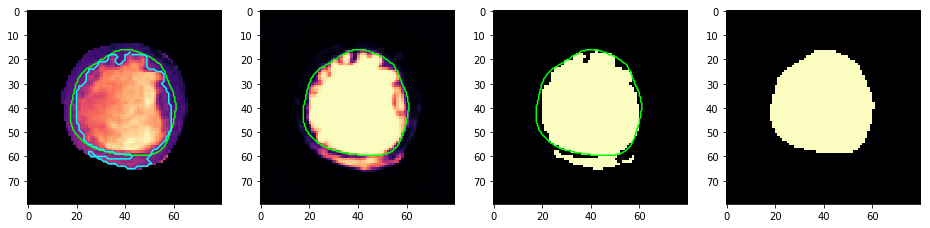

In [75]:
ii = 0
fig, axs = plt.subplots(1,4, figsize=(16, 5))
img, msk, contour = timgset_val[ii]
axs[0].imshow(img, cmap='magma')
axs[0].plot(contour[:,0], contour[:,1], c='lime')
axs[0].plot(contour_pred[:,0], contour_pred[:,1], c='cyan')
axs[1].set_title('prediction score');

axs[1].imshow(prediction_val[ii][...,0], cmap='magma')
axs[1].plot(contour[:,0], contour[:,1], c='lime')
axs[1].set_title('prediction score');

axs[2].imshow(prediction_val[ii][...,0]>0.5, cmap='magma')
axs[2].plot(contour[:,0], contour[:,1], c='lime')
axs[2].set_title('thresholded prediction');

axs[3].imshow(msk, cmap='magma')
plt.savefig('closeup_dl.png',)